<a href="https://colab.research.google.com/github/AishwaryaVelumani/Damage_Estimation_Using_Satellite_Imagery/blob/main/damage_estimation_single_test_img.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference: https://www.kaggle.com/code/debajyoti1/alexnet-hurricane-damage-detection

# Importing required libraries and fetching data from gdrive

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from glob import glob
import pandas as pd
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
#!kaggle datasets download -d kmader/satellite-images-of-hurricane-damage
#unzipping the zip files and deleting the zip files
#!unzip \*.zip  && rm *.zip

In [ ]:
!ls

kaggle.json				  test		 validation_another
satellite-images-of-hurricane-damage.zip  test_another
saved_model				  train_another


In [ ]:
!pwd

/content/gdrive/My Drive/Kaggle


# Image Preprocessing

In [ ]:
demo_test_img_path = r'model_data/train_another/no_damage/-95.627453_29.859303000000004.jpeg'

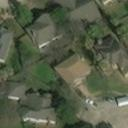

In [ ]:
image = cv2.imread(demo_test_img_path)
cv2_imshow(image)


In [ ]:
img_paths=[]
img_labels=[]
for i in glob('/content/gdrive/My Drive/Kaggle/model_data/**',recursive=True):
    if i.endswith('.jpeg'):
        a=i.split('/')
        img_paths.append(i)
        img_labels.append(a[-2])

In [ ]:
# a='train_another/no_damage/-95.627453_29.859303000000004.jpeg'
# b=a.split('/')
# print(b)
# print(b[-2])

['train_another', 'no_damage', '-95.627453_29.859303000000004.jpeg']
no_damage


In [ ]:
len(img_paths),len(img_labels)

(23000, 23000)

In [ ]:
img_path = pd.Series(img_paths).astype(str)
labels=pd.Series(img_labels)
data = pd.concat([img_path,labels],axis=1)
data.sample(5)

,0,1
7590,/content/gdrive/My Drive/Kaggle/test_another/d...,damage
1409,/content/gdrive/My Drive/Kaggle/validation_ano...,no_damage
4883,/content/gdrive/My Drive/Kaggle/test_another/d...,damage
11755,/content/gdrive/My Drive/Kaggle/test_another/d...,damage
15728,/content/gdrive/My Drive/Kaggle/train_another/...,damage


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
test_img_pd_path= pd.Series(demo_test_img_path).astype(str)
test_img_label=pd.Series('no_damage')
test_img_data= pd.concat([test_img_pd_path, test_img_label], axis=1)
print(test_img_data)

                                                   0          1
0  train_another/no_damage/-95.627453_29.85930300...  no_damage


In [ ]:
type(test_img_data)

pandas.core.frame.DataFrame

In [ ]:
data[0][0]

'/content/gdrive/My Drive/Kaggle/validation_another/damage/-93.558326_30.895248.jpeg'

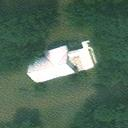

In [ ]:
image = cv2.imread(data[0][0])
cv2_imshow(image)

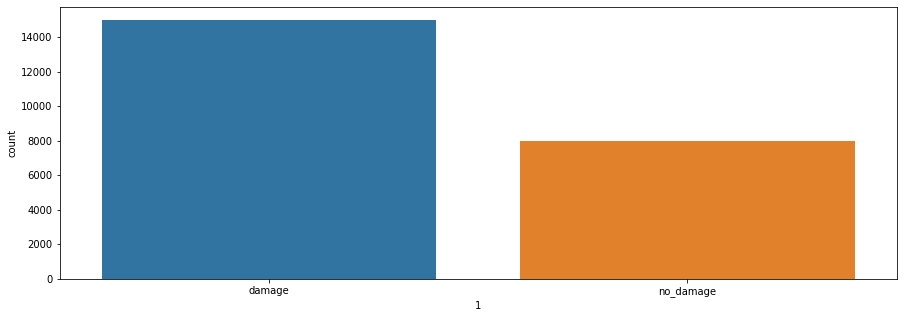

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(x=data[1])

In [ ]:
# data[1]

0           damage
1           damage
2           damage
3           damage
4           damage
           ...    
22995    no_damage
22996    no_damage
22997    no_damage
22998    no_damage
22999    no_damage
Name: 1, Length: 23000, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
train_set , test_set = train_test_split(data,test_size=0.25,random_state=0)
train_set.shape,test_set.shape

((17250, 2), (5750, 2))

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

In [ ]:
train_gen = ImageDataGenerator(validation_split=0.1,rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness)
#ImageDataGenerator: Generate batches of tensor image data with real-time data augmentation.
test_gen = ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness)

train_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training',
    batch_size=100,
    seed=2020
)
#The flow_from_dataframe() method takes the Pandas DataFrame 
#and the path to a directory and generates batches of augmented/normalized data.

val_data = train_gen.flow_from_dataframe(
    dataframe = train_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    subset = 'validation',
    batch_size=100,
    seed=2020
)

test_data = test_gen.flow_from_dataframe(
    dataframe = test_set,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size=100,
    seed=2020
)

Found 15525 validated image filenames belonging to 2 classes.
Found 1725 validated image filenames belonging to 2 classes.
Found 5750 validated image filenames belonging to 2 classes.


In [ ]:
test_img_data_from_gen= test_gen.flow_from_dataframe(
    dataframe= test_img_data,
    x_col = 0,
    y_col = 1,
    target_size = (227,227),
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = False,
    batch_size=1,
    seed=2020
    
)

Found 1 validated image filenames belonging to 1 classes.


In [ ]:
# print(type(train_gen))
# print(type(train_set))

<class 'keras.preprocessing.image.ImageDataGenerator'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# train_set.head()

,0,1
8728,/content/gdrive/My Drive/Kaggle/test_another/d...,damage
20413,/content/gdrive/My Drive/Kaggle/train_another/...,no_damage
19649,/content/gdrive/My Drive/Kaggle/train_another/...,no_damage
4476,/content/gdrive/My Drive/Kaggle/test_another/d...,damage
9369,/content/gdrive/My Drive/Kaggle/test_another/d...,damage


In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='sigmoid')
])
model.compile(
    optimizer=tf.optimizers.Adam(lr=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall']
)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
#history = model.fit(train_data,epochs=15,validation_data=val_data)
history = model.fit(train_data,epochs=1,validation_data=val_data)

156/156 [==============================] - 4114s 26s/step - loss: 1.0446 - accuracy: 0.6378 - recall: 0.6097 - val_loss: 0.5880 - val_accuracy: 0.6986 - val_recall: 0.7032


In [ ]:
# !mkdir -p saved_model
# model.save('saved_model/model_1_epoch') 

INFO:tensorflow:Assets written to: saved_model/model_1_epoch/assets


In [ ]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/model_1_epoch

model_1_epoch
assets	keras_metadata.pb  saved_model.pb  variables


In [ ]:
!pwd

/content/gdrive/MyDrive/Kaggle


In [ ]:
modele1 = tf.keras.models.load_model('model_data/saved_model/model_1_epoch')

# Check its architecture
modele1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Batc  (None, 27, 27, 256)      1024      
 hNormalization)                                                 
                                                        

In [ ]:
!pwd

/content/gdrive/MyDrive/Kaggle


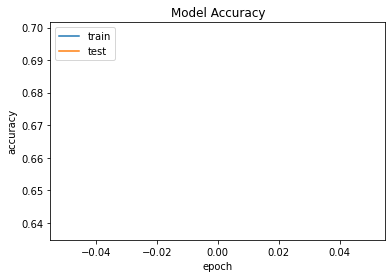

In [ ]:
import matplotlib.pyplot as plt
#plotting the Accuracy of test and training sets
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
y_pred = modele1.predict(test_data)
y_pred = np.argmax(y_pred,axis=1)

In [ ]:
y_pred_test_img= modele1.predict(test_img_data_from_gen)
y_pred_test_img = np.argmax(y_pred_test_img,axis=1)

In [ ]:
y_pred_test_img  # 1 IMAGE PREDICTION DONE

array([0])

In [ ]:
# y_pred_test_img_e1= modele1.predict(test_img_data_from_gen)
# y_pred_test_img_e1 = np.argmax(y_pred_test_img,axis=1)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_data.labels,y_pred))

In [ ]:
classes=['Damage','No Damage']
con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,y_pred),
                     index = classes, 
                     columns = classes)

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.cool,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()